# Pre-processing dati clorofilla a 300m

In questo foglio vengono fatte le prime valutazioni dui nuovi dati messi a disposizione da CMEMS e scaricati tramite ftp.


versione che gestisce diversamente il crop dei files

In [2]:
# import libraries for working with .nc
import xarray as xr
import os   
import numpy as np
import rioxarray



In [3]:
# origin path
pathOR = '/mnt/i/plankton/'
pathDEST = '/mnt/d/Dropbox/R_projects/SV_phenology/data/daily300m_bis/'
pathCOARS =  '/mnt/d/Dropbox/R_projects/SV_phenology/data/daily300m_coarsened/'
pathOLD = '/mnt/d/Dropbox/R_projects/SV_phenology/data/daily_coarsened/'

carico un file di esempio

20220612_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc

In [4]:
year = 2022
month = 7
day = 18

# load this file s_subset.to_netcdf(outp + '{}'.format(year) + '/CHL_03-10_{}_{}.nc'.format(year, month), encoding=encoding)as a xarray dataset
ds = xr.open_dataset(pathOR + '{}'.format(year) + '/' +  '{:02d}'.format(month) + '/{}{:02d}{:02d}_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc'.format(year, month, day))


  # save the subset to a NetCDF file with the updated encoding (nome file= outp + year + 'CHL_03-10_{}_.nc'.format(year))
 #       ds_subset.to_netcdf(outp + '{}'.format(year) + '/CHL_03-10_{}_{}.nc'.format(year, month), encoding=encoding)
               
ds


<xarray.Dataset>
Dimensions:        (time: 1, y: 18345, x: 18345)
Coordinates:
  * time           (time) datetime64[ns] 2022-07-18
  * y              (y) float32 -2.752e+06 -2.751e+06 ... 2.751e+06 2.752e+06
  * x              (x) float32 -2.752e+06 -2.751e+06 ... 2.751e+06 2.752e+06
    lat            (y, x) float32 ...
    lon            (y, x) float32 ...
Data variables:
    stereographic  int32 ...
    SENSORMASK     (time, y, x) float32 ...
    CHL            (time, y, x) float32 ...
Attributes: (12/34)
    netcdf_version:          v4
    Conventions:             CF-1.4
    platform:                Sentinel3A+B
    product_level:           L3
    contact:                 technical@gos.artov.isac.cnr.it
    references:              Zoffoli et al. (in preparation)
    ...                      ...
    noqi:                    No climatatology data available
    title:                   cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D
    cmems_product_id:        OCEANCOLOUR_ARC_BGC_L3_MY_009_123
    stop_date:               2022-07-18
    creation_date:           2023-09-01
    creation_time:           03:47:59 UTC

In [5]:
# plot the data
#ds.CHL.plot()

In [6]:
# carico una già coarsened
ds_co = xr.open_dataset(pathOLD + '{}'.format(year) + '/CHL_03-10_{}_{}.nc'.format(year, month))
# seleziono il 12 giugno
ds_co = ds_co.sel(time='{}-{:02d}-{:02d}'.format(year, month, day))
ds_co

<xarray.Dataset>
Dimensions:    (latitude: 1248, longitude: 1056)
Coordinates:
    time       datetime64[ns] 2022-07-18
  * latitude   (latitude) float64 84.99 84.98 84.97 84.96 ... 72.03 72.02 72.01
  * longitude  (longitude) float64 -4.995 -4.943 -4.891 ... 49.85 49.9 49.95
Data variables:
    CHL        (latitude, longitude) float32 ...

In [7]:
# Extract min and max latitude and longitude from ds_co
min_lat = 65
max_lat = 88
min_lon = -15
max_lon = 70

# Find the indices where lat and lon from ds fall within the bounds of ds_co
lat_mask = (ds.lat >= min_lat) & (ds.lat <= max_lat)
lon_mask = (ds.lon >= min_lon) & (ds.lon <= max_lon)
combined_mask = lat_mask & lon_mask

# Get the min and max x, y indices
y_indices, x_indices = np.where(combined_mask)
min_x, max_x = x_indices.min(), x_indices.max()
min_y, max_y = y_indices.min(), y_indices.max()

# Use these indices to select the portion from ds
ds_cropped = ds.isel(y=slice(min_y, max_y), x=slice(min_x, max_x))

print(ds_cropped)

<xarray.Dataset>
Dimensions:        (time: 1, y: 11813, x: 8805)
Coordinates:
  * time           (time) datetime64[ns] 2022-07-18
  * y              (y) float32 -2.382e+06 -2.382e+06 ... 1.162e+06 1.162e+06
  * x              (x) float32 1.086e+05 1.089e+05 ... 2.75e+06 2.75e+06
    lat            (y, x) float32 68.25 68.25 68.25 68.25 ... 62.94 62.94 62.94
    lon            (y, x) float32 -42.39 -42.38 -42.38 ... 67.91 67.91 67.91
Data variables:
    stereographic  int32 ...
    SENSORMASK     (time, y, x) float32 ...
    CHL            (time, y, x) float32 ...
Attributes: (12/34)
    netcdf_version:          v4
    Conventions:             CF-1.4
    platform:                Sentinel3A+B
    product_level:           L3
    contact:                 technical@gos.artov.isac.cnr.it
    references:              Zoffoli et al. (in preparation)
    ...                      ...
    noqi:                    No climatatology data available
    title:                   cmems_obs-oc_arc_bgc-pl

In [8]:
# plot ds_cropped
#ds_cropped.CHL.plot()

calcolo le risoluzioni di destinazione


In [9]:
import math

# Latitudine
lat_extent = 300 / 111000

# Longitudine
lon_extent = 300 / (111000 * math.cos(math.radians(78)))


lat_extent, lon_extent

(0.002702702702702703, 0.012999282012821967)

In [10]:


# Set the original dataset's crs 
ds_cropped2 = ds_cropped[['CHL']]  # Only include the CHL data variable for now
ds_cropped2 = ds_cropped2.drop_vars(["lat", "lon"])

# specifica il sistema di riferimento proj4	+proj=stere +lon_0=-45 +lat_0=90 +k=1 +R=6378273


#ds_cropped2 = ds_cropped2.rio.write_crs("EPSG:32662")  # Replace xxxx with the EPSG code of your source CRS.
ds_cropped2 = ds_cropped2.rio.write_crs("+proj=stere +lon_0=-45 +lat_0=90 +k=1 +R=6378273")

# Reproject the dataset to WGS84 (EPSG:4326)
ds_reprojected = ds_cropped2.rio.reproject("EPSG:4326", resolution=(lon_extent, lat_extent))

In [11]:
ds_reprojected

<xarray.Dataset>
Dimensions:        (x: 13237, y: 11420, time: 1)
Coordinates:
  * x              (x) float64 -42.39 -42.37 -42.36 -42.35 ... 129.6 129.7 129.7
  * y              (y) float64 89.02 89.02 89.02 89.01 ... 58.17 58.16 58.16
  * time           (time) datetime64[ns] 2022-07-18
    stereographic  int64 0
Data variables:
    CHL            (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/34)
    netcdf_version:          v4
    Conventions:             CF-1.4
    platform:                Sentinel3A+B
    product_level:           L3
    contact:                 technical@gos.artov.isac.cnr.it
    references:              Zoffoli et al. (in preparation)
    ...                      ...
    noqi:                    No climatatology data available
    title:                   cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D
    cmems_product_id:        OCEANCOLOUR_ARC_BGC_L3_MY_009_123
    stop_date:               2022-07-18
    creation_date:           2023-09-01
    creation_time:           03:47:59 UTC

In [12]:
ds_reprojected

<xarray.Dataset>
Dimensions:        (x: 13237, y: 11420, time: 1)
Coordinates:
  * x              (x) float64 -42.39 -42.37 -42.36 -42.35 ... 129.6 129.7 129.7
  * y              (y) float64 89.02 89.02 89.02 89.01 ... 58.17 58.16 58.16
  * time           (time) datetime64[ns] 2022-07-18
    stereographic  int64 0
Data variables:
    CHL            (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/34)
    netcdf_version:          v4
    Conventions:             CF-1.4
    platform:                Sentinel3A+B
    product_level:           L3
    contact:                 technical@gos.artov.isac.cnr.it
    references:              Zoffoli et al. (in preparation)
    ...                      ...
    noqi:                    No climatatology data available
    title:                   cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D
    cmems_product_id:        OCEANCOLOUR_ARC_BGC_L3_MY_009_123
    stop_date:               2022-07-18
    creation_date:           2023-09-01
    creation_time:           03:47:59 UTC

In [13]:
#ds_reprojected.CHL.plot()

crop all'area di studio

In [14]:
ds_reprojected

# crop ds reprojected to the same extent of the coarsened one
ds_reprojected = ds_reprojected.sel(y=slice(ds_co.latitude.values[0], ds_co.latitude.values[-1]), x=slice(ds_co.longitude.values[0], ds_co.longitude.values[-1]))

In [15]:
ds_reprojected

<xarray.Dataset>
Dimensions:        (x: 4227, y: 4806, time: 1)
Coordinates:
  * x              (x) float64 -4.988 -4.975 -4.962 -4.949 ... 49.92 49.93 49.95
  * y              (y) float64 84.99 84.99 84.99 84.98 ... 72.01 72.01 72.01
  * time           (time) datetime64[ns] 2022-07-18
    stereographic  int64 0
Data variables:
    CHL            (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/34)
    netcdf_version:          v4
    Conventions:             CF-1.4
    platform:                Sentinel3A+B
    product_level:           L3
    contact:                 technical@gos.artov.isac.cnr.it
    references:              Zoffoli et al. (in preparation)
    ...                      ...
    noqi:                    No climatatology data available
    title:                   cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D
    cmems_product_id:        OCEANCOLOUR_ARC_BGC_L3_MY_009_123
    stop_date:               2022-07-18
    creation_date:           2023-09-01
    creation_time:           03:47:59 UTC

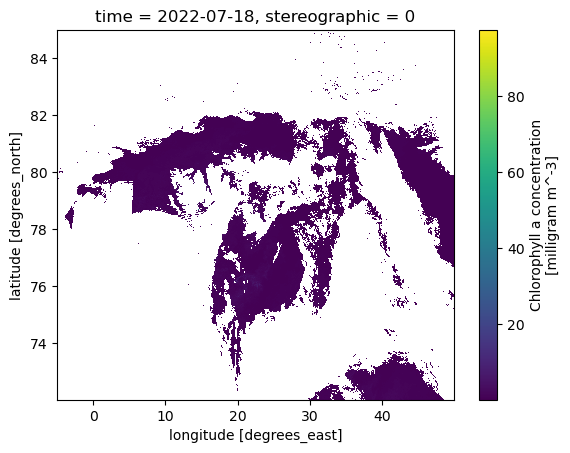

In [16]:
ds_reprojected.CHL.plot()

tutto sembra tornare

ora ritorno alla proiezione originaria

In [17]:
#ds_reprojected = ds_reprojected.rio.write_crs("EPSG:4326")

# riproietta nel sistema "+proj=stere +lon_0=-45 +lat_0=90 +k=1 +R=6378273"
ds_reprojected_back = ds_reprojected.rio.reproject("+proj=stere +lon_0=-45 +lat_0=90 +k=1 +R=6378273", resolution=(300, 300))

In [18]:
ds_reprojected_back

<xarray.Dataset>
Dimensions:        (x: 5538, y: 5739, time: 1)
Coordinates:
  * x              (x) float64 3.587e+05 3.59e+05 ... 2.019e+06 2.02e+06
  * y              (y) float64 1.743e+05 1.74e+05 ... -1.547e+06 -1.547e+06
  * time           (time) datetime64[ns] 2022-07-18
    stereographic  int64 0
Data variables:
    CHL            (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/34)
    netcdf_version:          v4
    Conventions:             CF-1.4
    platform:                Sentinel3A+B
    product_level:           L3
    contact:                 technical@gos.artov.isac.cnr.it
    references:              Zoffoli et al. (in preparation)
    ...                      ...
    noqi:                    No climatatology data available
    title:                   cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D
    cmems_product_id:        OCEANCOLOUR_ARC_BGC_L3_MY_009_123
    stop_date:               2022-07-18
    creation_date:           2023-09-01
    creation_time:           03:47:59 UTC

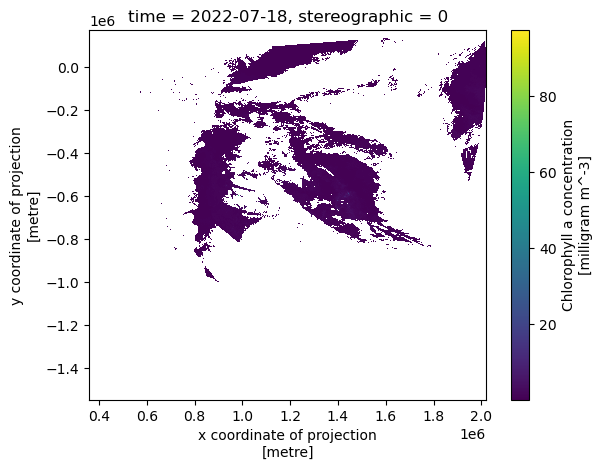

In [19]:
ds_reprojected_back.CHL.plot()

In [20]:
ds

<xarray.Dataset>
Dimensions:        (time: 1, y: 18345, x: 18345)
Coordinates:
  * time           (time) datetime64[ns] 2022-07-18
  * y              (y) float32 -2.752e+06 -2.751e+06 ... 2.751e+06 2.752e+06
  * x              (x) float32 -2.752e+06 -2.751e+06 ... 2.751e+06 2.752e+06
    lat            (y, x) float32 55.15 55.15 55.15 55.16 ... 55.15 55.15 55.15
    lon            (y, x) float32 -90.0 -90.0 -89.99 -89.99 ... 90.01 90.0 90.0
Data variables:
    stereographic  int32 ...
    SENSORMASK     (time, y, x) float32 ...
    CHL            (time, y, x) float32 ...
Attributes: (12/34)
    netcdf_version:          v4
    Conventions:             CF-1.4
    platform:                Sentinel3A+B
    product_level:           L3
    contact:                 technical@gos.artov.isac.cnr.it
    references:              Zoffoli et al. (in preparation)
    ...                      ...
    noqi:                    No climatatology data available
    title:                   cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D
    cmems_product_id:        OCEANCOLOUR_ARC_BGC_L3_MY_009_123
    stop_date:               2022-07-18
    creation_date:           2023-09-01
    creation_time:           03:47:59 UTC

In [21]:
min_x = ds_reprojected_back.x.min().values
max_x = ds_reprojected_back.x.max().values
min_y = ds_reprojected_back.y.min().values
max_y = ds_reprojected_back.y.max().values

# Find the index positions in ds1 that correspond to these bounding coordinates
min_x_index = (abs(ds.x - min_x)).argmin().values
max_x_index = (abs(ds.x - max_x)).argmin().values
min_y_index = (abs(ds.y - min_y)).argmin().values
max_y_index = (abs(ds.y - max_y)).argmin().values

nearest_xmin = ds['x'].sel(x=min_x, method='nearest').values
nearest_xmax = ds['x'].sel(x=max_x, method='nearest').values
nearest_ymin = ds['y'].sel(y=min_y, method='nearest').values
nearest_ymax = ds['y'].sel(y=max_y, method='nearest').values


# Use these index positions to slice ds1 using isel
cropped_ds = ds.sel(x=slice(nearest_xmin, nearest_xmax), y=slice(nearest_ymin, nearest_ymax))
cropped_ds

<xarray.Dataset>
Dimensions:        (time: 1, y: 5739, x: 5538)
Coordinates:
  * time           (time) datetime64[ns] 2022-07-18
  * y              (y) float32 -1.547e+06 -1.547e+06 ... 1.74e+05 1.743e+05
  * x              (x) float32 3.585e+05 3.588e+05 ... 2.019e+06 2.02e+06
    lat            (y, x) float32 75.42 75.42 75.42 75.41 ... 71.45 71.45 71.44
    lon            (y, x) float32 -31.95 -31.94 -31.93 ... 49.93 49.93 49.93
Data variables:
    stereographic  int32 ...
    SENSORMASK     (time, y, x) float32 ...
    CHL            (time, y, x) float32 ...
Attributes: (12/34)
    netcdf_version:          v4
    Conventions:             CF-1.4
    platform:                Sentinel3A+B
    product_level:           L3
    contact:                 technical@gos.artov.isac.cnr.it
    references:              Zoffoli et al. (in preparation)
    ...                      ...
    noqi:                    No climatatology data available
    title:                   cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D
    cmems_product_id:        OCEANCOLOUR_ARC_BGC_L3_MY_009_123
    stop_date:               2022-07-18
    creation_date:           2023-09-01
    creation_time:           03:47:59 UTC

In [22]:
# drop time
cropped_ds2 = cropped_ds.drop_vars(["time"])
# drop lat and lon
cropped_ds2 = cropped_ds2.drop_vars(["lat", "lon"])


cropped_ds2

<xarray.Dataset>
Dimensions:        (y: 5739, x: 5538, time: 1)
Coordinates:
  * y              (y) float32 -1.547e+06 -1.547e+06 ... 1.74e+05 1.743e+05
  * x              (x) float32 3.585e+05 3.588e+05 ... 2.019e+06 2.02e+06
Dimensions without coordinates: time
Data variables:
    stereographic  int32 ...
    SENSORMASK     (time, y, x) float32 ...
    CHL            (time, y, x) float32 ...
Attributes: (12/34)
    netcdf_version:          v4
    Conventions:             CF-1.4
    platform:                Sentinel3A+B
    product_level:           L3
    contact:                 technical@gos.artov.isac.cnr.it
    references:              Zoffoli et al. (in preparation)
    ...                      ...
    noqi:                    No climatatology data available
    title:                   cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D
    cmems_product_id:        OCEANCOLOUR_ARC_BGC_L3_MY_009_123
    stop_date:               2022-07-18
    creation_date:           2023-09-01
    creation_time:           03:47:59 UTC

In [23]:
# riproietta nel sistema "+proj=stere +lon_0=-45 +lat_0=90 +k=1 +R=6378273"
cropped_ds2 = cropped_ds2.rio.write_crs("+proj=stere +lon_0=-45 +lat_0=90 +k=1 +R=6378273")
# drop time
#cropped_ds2 = cropped_ds2.drop_vars('time')

cropped_dsdeg = cropped_ds2.rio.reproject("EPSG:4326", resolution=(lon_extent, lat_extent))

# croppo a ds_co
cropped_dsdeg = cropped_dsdeg.sel(y=slice(ds_co.latitude.values[0], ds_co.latitude.values[-1]), x=slice(ds_co.longitude.values[0], ds_co.longitude.values[-1]))
cropped_dsdeg

<xarray.Dataset>
Dimensions:        (x: 4227, y: 4806, time: 1)
Coordinates:
  * x              (x) float64 -4.993 -4.98 -4.967 -4.954 ... 49.92 49.93 49.94
  * y              (y) float64 84.99 84.99 84.99 84.99 ... 72.01 72.01 72.01
    stereographic  int64 0
Dimensions without coordinates: time
Data variables:
    SENSORMASK     (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    CHL            (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/34)
    netcdf_version:          v4
    Conventions:             CF-1.4
    platform:                Sentinel3A+B
    product_level:           L3
    contact:                 technical@gos.artov.isac.cnr.it
    references:              Zoffoli et al. (in preparation)
    ...                      ...
    noqi:                    No climatatology data available
    title:                   cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D
    cmems_product_id:        OCEANCOLOUR_ARC_BGC_L3_MY_009_123
    stop_date:               2022-07-18
    creation_date:           2023-09-01
    creation_time:           03:47:59 UTC

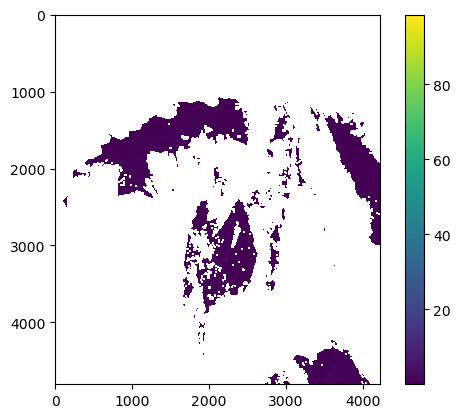

In [24]:
import matplotlib.pyplot as plt

plt.imshow(cropped_dsdeg.CHL[0].values, origin='upper')  # Assuming time is the 0th index
plt.colorbar()
plt.show()

ora provo a fare il crop del file originario prendendo come riferimento il nuovo file riproiettato indietro

In [25]:
# set consistent _FillValue and missing_value attributes for the 'CHL' variable
encoding = {'CHL': {'_FillValue': -999.0, 'missing_value': -999.0}}



## Processamento immagini

procedo a modificare tutte le immagini riproiettando e ricampionando


In [26]:
pathDEST
pathCOARS

# creo le cartelle, se non esistono
if not os.path.exists(pathDEST):
    os.makedirs(pathDEST)
    
    
if not os.path.exists(pathCOARS):
    os.makedirs(pathCOARS)
    


ricontrollo la risoluzione

le celle sono quasi quadrate!

In [27]:
# creo la cartella path =  '/mnt/d/Dropbox/R_projects/SV_phenology/data/test_coarsened e salvo il file
# creo la cartella se non esiste già
#os.makedirs('/mnt/d/Dropbox/R_projects/SV_phenology/data/test_coarsened', exist_ok=True)

#ds_coarsened.to_netcdf('/mnt/d/Dropbox/R_projects/SV_phenology/data/test_coarsened' + '/CHL_03-10_{}_{}_coarsenedv2.nc'.format(year, month))


In [28]:

os.makedirs(pathDEST + '{}'.format(year), exist_ok=True)

os.makedirs(pathCOARS + '{}'.format(year), exist_ok=True)



In [29]:
pathOR + '{}'.format(year) +  '/' + '{:02d}'.format(month) 

'/mnt/i/plankton/2022/07'

In [30]:
# carica tutti i file .nc in una cartella
#path = '/mnt/d/Dropbox/R_projects/SV_phenology/data/daily300m/2020'
#path = '/mnt/d/Dropbox/R_projects/SV_phenology/data/daily300m/2021'

#dsm = xr.open_mfdataset(pathOR + '{}'.format(year) +  '/' + '{:02d}'.format(month) + '/*.nc', combine='by_coords')

In [31]:
flist = os.listdir(pathOR + '{}'.format(year) +  '/' + '{:02d}'.format(month))


# delete the elements of the list that are not .nc files
flist = [x for x in flist if x.endswith(".nc")]


flist

['20220701_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc',
 '20220702_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc',
 '20220703_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc',
 '20220704_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc',
 '20220705_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc',
 '20220706_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc',
 '20220707_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc',
 '20220708_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc',
 '20220709_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc',
 '20220710_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc',
 '20220711_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc',
 '20220712_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc',
 '20220713_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc',
 '20220714_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc',
 '20220715_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc',
 '20220716

In [32]:
cropped_ds = ds.sel(x=slice(nearest_xmin, nearest_xmax), y=slice(nearest_ymin, nearest_ymax))
cropped_ds = cropped_ds[['CHL']]  # Only include the CHL data variable for now
cropped_ds = cropped_ds.rename({'x': 'longitude', 'y': 'latitude'})
cropped_ds = cropped_ds.drop_vars(["lat", "lon"])
cropped_ds

<xarray.Dataset>
Dimensions:    (time: 1, latitude: 5739, longitude: 5538)
Coordinates:
  * time       (time) datetime64[ns] 2022-07-18
  * latitude   (latitude) float32 -1.547e+06 -1.547e+06 ... 1.74e+05 1.743e+05
  * longitude  (longitude) float32 3.585e+05 3.588e+05 ... 2.019e+06 2.02e+06
Data variables:
    CHL        (time, latitude, longitude) float32 ...
Attributes: (12/34)
    netcdf_version:          v4
    Conventions:             CF-1.4
    platform:                Sentinel3A+B
    product_level:           L3
    contact:                 technical@gos.artov.isac.cnr.it
    references:              Zoffoli et al. (in preparation)
    ...                      ...
    noqi:                    No climatatology data available
    title:                   cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D
    cmems_product_id:        OCEANCOLOUR_ARC_BGC_L3_MY_009_123
    stop_date:               2022-07-18
    creation_date:           2023-09-01
    creation_time:           03:47:59 UTC

In [33]:
import os
import xarray as xr
from dask.distributed import Client

# Inizializza un cluster Dask


# set consistent _FillValue and missing_value attributes for the 'CHL' variable
encoding = {'CHL': {'_FillValue': -999.0, 'missing_value': -999.0}}

# loop for each year within 1998 and 2022
for year in range(2022, 2024):
    
    # create a folder for each year in path outh, if does not exist already
    os.makedirs(os.path.join(pathDEST, str(year)), exist_ok=True)
    
    for month in range(3, 11):
        
        month_dir = os.path.join(pathOR, str(year), '{:02d}'.format(month))
        dest_dir = os.path.join(pathDEST, str(year), '{:02d}'.format(month))
        os.makedirs(dest_dir, exist_ok=True)
        
        # elenco files in pathOR + '{}'.format(year) +  '/' + '{:02d}'.format(month) 
        flist = os.listdir(month_dir)
        flist = [x for x in flist if x.endswith(".nc")]
        
        # per ogni file in flist
        for file in flist:
            
            # Check if the file already exists in the destination directory
            if os.path.exists(os.path.join(dest_dir, file)):
                print(f"File {file} already exists in destination. Skipping...")
                continue
            
            # leggo il file in modalità lazy con chunks
            ds = xr.open_dataset(os.path.join(month_dir, file))
            
            # croppo all'estensione spaziale di ds_reprojected_back
            cropped_ds = ds.sel(x=slice(nearest_xmin, nearest_xmax), y=slice(nearest_ymin, nearest_ymax))
            cropped_ds = cropped_ds[['CHL']]  # Only include the CHL data variable for now
            cropped_ds = cropped_ds.rename({'x': 'longitude', 'y': 'latitude'})
            cropped_ds = cropped_ds.drop_vars(["lat", "lon"])

            # reproject
            cropped_ds = cropped_ds.rio.write_crs("+proj=stere +lon_0=-45 +lat_0=90 +k=1 +R=6378273")  # Replace xxxx with the EPSG code of your source CRS.
            ds_reprojected = cropped_ds.rio.reproject("EPSG:4326", resolution=(lon_extent, lat_extent))
            
            # crop ds reprojected to the same extent of the coarsened one
            ds_reprojected = ds_reprojected.sel(y=slice(ds_co.latitude.values[0], ds_co.latitude.values[-1]), x=slice(ds_co.longitude.values[0], ds_co.longitude.values[-1]))
            
            # save the subset to a NetCDF file with the updated encoding
            ds_reprojected.to_netcdf(os.path.join(dest_dir, file), encoding=encoding)
            
            print(year, month, file)

            # close the datasets
            ds.close()
            ds_cropped.close()
            ds_reprojected.close()

# Chiudi il client Dask alla fine delle operazioni
client.close()



File 20220301_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc already exists in destination. Skipping...
File 20220302_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc already exists in destination. Skipping...
File 20220303_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc already exists in destination. Skipping...
File 20220304_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc already exists in destination. Skipping...
File 20220305_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc already exists in destination. Skipping...
File 20220306_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc already exists in destination. Skipping...
File 20220307_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc already exists in destination. Skipping...
File 20220308_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc already exists in destination. Skipping...
File 20220309_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc already exists in destination. Skipping...
File 20220

File 20230609_cmems_obs-oc_arc_bgc-plankton_myint_l3-olci-300m_P1D.nc already exists in destination. Skipping...
File 20230610_cmems_obs-oc_arc_bgc-plankton_myint_l3-olci-300m_P1D.nc already exists in destination. Skipping...
File 20230611_cmems_obs-oc_arc_bgc-plankton_myint_l3-olci-300m_P1D.nc already exists in destination. Skipping...
File 20230612_cmems_obs-oc_arc_bgc-plankton_myint_l3-olci-300m_P1D.nc already exists in destination. Skipping...
File 20230613_cmems_obs-oc_arc_bgc-plankton_myint_l3-olci-300m_P1D.nc already exists in destination. Skipping...
File 20230614_cmems_obs-oc_arc_bgc-plankton_myint_l3-olci-300m_P1D.nc already exists in destination. Skipping...
File 20230615_cmems_obs-oc_arc_bgc-plankton_myint_l3-olci-300m_P1D.nc already exists in destination. Skipping...
File 20230616_cmems_obs-oc_arc_bgc-plankton_myint_l3-olci-300m_P1D.nc already exists in destination. Skipping...
File 20230617_cmems_obs-oc_arc_bgc-plankton_myint_l3-olci-300m_P1D.nc already exists in destinat

NameError: name 'client' is not defined

In [31]:
client.close()

In [34]:
print(flist)

['20220601_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc', '20220602_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc', '20220603_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc', '20220604_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc', '20220605_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc', '20220606_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc', '20220607_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc', '20220608_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc', '20220609_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc', '20220610_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc', '20220611_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc', '20220612_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc', '20220613_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc', '20220614_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc', '20220615_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc', '20220616_cmems_obs-oc_a

In [28]:
path =  '/mnt/d/Dropbox/R_projects/SV_phenology/data/daily/'

pathout = '/mnt/d/Dropbox/R_projects/SV_phenology/data/daily_coarsened/'


# set consistent _FillValue and missing_value attributes for the 'CHL' variable
encoding = {'CHL': {'_FillValue': -999.0, 'missing_value': -999.0}}


# loop for each year within 1998 and 2022
for year in range(2022,2023):
    # loop for each month within march and october

    # create a folder for each year in path outh, if does not exist already
    os.makedirs(pathDEST + '{}'.format(year) , exist_ok=True)
    
    for month in range(4, 11):
        
        os.makedirs(pathDEST + '{}'.format(year) +  '/' + '{:}'.format(month), exist_ok=True)
        
        # elenco files in pathOR + '{}'.format(year) +  '/' + '{:02d}'.format(month) 
        flist = os.listdir(pathOR + '{}'.format(year) +  '/' + '{:02d}'.format(month))
        
        # per ogni file in flist
        for file in flist:
            
            # leggo il file
            ds = xr.open_dataset(pathOR + '{}'.format(year) +  '/' + '{:02d}'.format(month) + '/' + file)
            
            # croppo
            ds_cropped = ds.isel(y=slice(min_y, max_y), x=slice(min_x, max_x))
            ds_cropped = ds_cropped[['CHL']]  # Only include the CHL data variable for now
            ds_cropped = ds_cropped.drop_vars(["lat", "lon"])

            # reproject
            ds_cropped = ds_cropped.rio.write_crs("EPSG:3996")  # Replace xxxx with the EPSG code of your source CRS.
            ds_reprojected = ds_cropped.rio.reproject("EPSG:4326")
            
            # crop ds reprojected to the same extent of the coarsened one
            ds_reprojected = ds_reprojected.sel(y=slice(ds_co.latitude.values[0], ds_co.latitude.values[-1]), x=slice(ds_co.longitude.values[0], ds_co.longitude.values[-1]))
            
            # save the subset to a NetCDF file with the updated encoding (nome file= outp + year + 'CHL_03-10_{}_.nc'.format(year))
            ds_reprojected.to_netcdf(pathDEST + '{}'.format(year) +  '/' + '{:02d}'.format(month) +  '/' + file, encoding=encoding)
            
            print(year, month, file)

        # close the dataset
        ds.close()

        # close the subset
        ds_cropped.close()
        ds_reprojected.close()
        
  
        

2022 3 20220301_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc
2022 3 20220302_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc
2022 3 20220303_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc
2022 3 20220304_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc
2022 3 20220305_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc
2022 3 20220306_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc
2022 3 20220307_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc
2022 3 20220308_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc
2022 3 20220309_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc
2022 3 20220310_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc
2022 3 20220311_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc
2022 3 20220312_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc
2022 3 20220313_cmems_obs-oc_arc_bgc-plankton_my_l3-olci-300m_P1D.nc


: 

# Loop for interpolation

In [28]:
path =  '/mnt/d/Dropbox/R_projects/SV_phenology/data/daily/'

pathout = '/mnt/d/Dropbox/R_projects/SV_phenology/data/daily_coarsened/'


# set consistent _FillValue and missing_value attributes for the 'CHL' variable
encoding = {'CHL': {'_FillValue': -999.0, 'missing_value': -999.0}}


# loop for each year within 1998 and 2022
for year in range(1998,2023):
    # loop for each month within march and october

    # create a folder for each year in path outh, if does not exist already
    os.makedirs(pathout + '{}'.format(year), exist_ok=True)
    
    for month in range(4, 11):
        # temp path concatenate folder for year and month (e.g. 1998/03), with month in two digits

        ds = xr.open_dataset(path + '{}'.format(year) + '/CHL_03-10_{}_{}.nc'.format(year, month))
        
        # read the size of the cells
        delta_longitude = abs(ds.longitude.values[1] - ds.longitude.values[0])


        # coarsen the dataset
        ds_coarsened = ds.interp(longitude=np.arange(ds.longitude[0], ds.longitude[-1], step = 5 * delta_longitude), method='nearest')


        # save the subset to a NetCDF file with the updated encoding (nome file= outp + year + 'CHL_03-10_{}_.nc'.format(year))
        ds_coarsened.to_netcdf(pathout + '{}'.format(year) + '/CHL_03-10_{}_{}.nc'.format(year, month), encoding=encoding)
               

        # close the dataset
        ds.close()

        # close the subset
        ds_coarsened.close()

        # print the year and month
        print(year, month)
        




 

1998 3
1998 4
1998 5
1998 6
1998 7
1998 8
1998 9
1998 10
1999 3
1999 4
1999 5
1999 6
1999 7
1999 8
1999 9
1999 10
2000 3
2000 4
2000 5
2000 6
2000 7
2000 8
2000 9
2000 10
2001 3
2001 4
2001 5
2001 6
2001 7
2001 8
2001 9
2001 10
2002 3
2002 4
2002 5
2002 6
2002 7
2002 8
2002 9
2002 10
2003 3
2003 4
2003 5
2003 6
2003 7
2003 8
2003 9
2003 10
2004 3
2004 4
2004 5
2004 6
2004 7
2004 8
2004 9
2004 10
2005 3
2005 4
2005 5
2005 6
2005 7
2005 8
2005 9
2005 10
2006 3
2006 4
2006 5
2006 6
2006 7
2006 8
2006 9
2006 10
2007 3
2007 4
2007 5
2007 6
2007 7
2007 8
2007 9
2007 10
2008 3
2008 4
2008 5
2008 6
2008 7
2008 8
2008 9
2008 10
2009 3
2009 4
2009 5
2009 6
2009 7
2009 8
2009 9
2009 10
2010 3
2010 4
2010 5
2010 6
2010 7
2010 8
2010 9
2010 10
2011 3
2011 4
2011 5
2011 6
2011 7
2011 8
2011 9
2011 10
2012 3
2012 4
2012 5
2012 6
2012 7
2012 8
2012 9
2012 10
2013 3
2013 4
2013 5
2013 6
2013 7
2013 8
2013 9
2013 10
2014 3
2014 4
2014 5
2014 6
2014 7
2014 8
2014 9
2014 10
2015 3
2015 4
2015 5
2015 6
201